# Load 

In [1]:
import pandas as pd
from geopy.distance import geodesic

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Import geo data

https://gadm.org/download_country.html

# load files

In [2]:
# Load weather dataset
weather_df = pd.read_csv("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/region_weather_epirus_patched.csv")
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Load MODIS fire data
modis_path = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/fire_archive_M-C61_586436.csv"
modis_df = pd.read_csv(modis_path)
modis_df['acq_date'] = pd.to_datetime(modis_df['acq_date'])

# Load GADM regions
gadm = gpd.read_file("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/gadm41_GRC_1.json")
gadm = gadm.rename(columns={'NAME_1': 'region'})
#greece_regions = greece_regions.rename(columns={"NAME_1": "region"})

In [3]:
print(len(modis_df))
print(len(weather_df))

45141
62919


In [4]:
weather_df['region'].value_counts()

region
Aegean                          9132
Crete                           9132
Peloponnese,WesternGreeceand    9132
MacedoniaandThrace              9126
Attica                          9117
ThessalyandCentralGreece        8882
EpirusandWesternMacedonia       8398
Name: count, dtype: int64

In [3]:
modis_df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,40.8941,21.4627,307.4,1.1,1.0,2000-11-01,953,Terra,MODIS,60,6.03,288.3,7.5,D,0
1,38.6703,22.5078,312.2,1.2,1.1,2000-11-01,953,Terra,MODIS,72,6.03,297.9,8.2,D,0
2,39.0664,22.4310,308.5,1.2,1.1,2000-11-01,953,Terra,MODIS,66,6.03,294.9,5.7,D,0
3,41.2814,26.2883,303.0,1.2,1.1,2000-11-03,940,Terra,MODIS,51,6.03,292.1,5.5,D,0
4,39.9170,22.5219,302.0,1.0,1.0,2000-11-03,941,Terra,MODIS,47,6.03,290.7,4.1,D,0


In [5]:
weather_df.head()

,region,date,temp_avg,temp_max,temp_min,precip,snow_depth,wind_dir,wind_speed,wind_gust,pressure,sunshine_duration
0,Aegean,2000-01-01,12.325000,14.850000,10.900000,7.1,NaN,309.0,17.333333,NaN,NaN,NaN
1,Aegean,2000-01-02,10.475000,11.700000,8.800000,0.0,NaN,192.5,16.566667,NaN,NaN,NaN
2,Aegean,2000-01-03,7.066667,8.733333,4.933333,1.3,NaN,184.5,33.950000,NaN,NaN,NaN
3,Aegean,2000-01-04,6.350000,7.500000,5.250000,0.0,NaN,330.0,36.200000,NaN,NaN,NaN
4,Aegean,2000-01-05,6.500000,8.533333,3.466667,0.0,NaN,317.0,21.050000,NaN,NaN,NaN


# Plot historical wildfires 

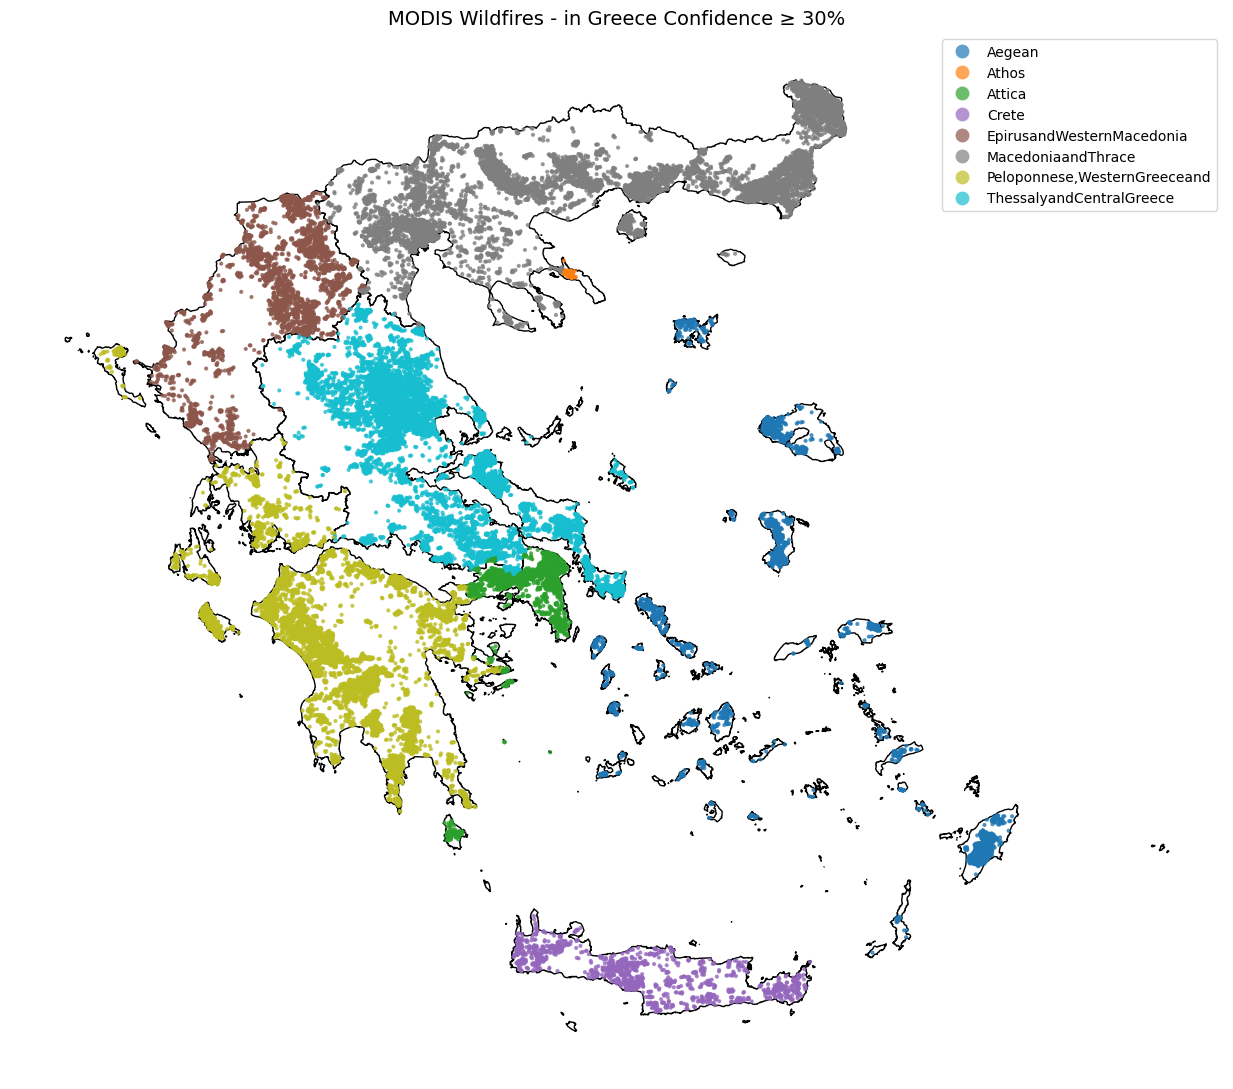

In [32]:
# Load Greece region boundaries (GADM Level 1)
greece_regions = gpd.read_file("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/gadm41_GRC_1.json")
greece_regions = greece_regions.rename(columns={"NAME_1": "region"})
# --- Spatial join to assign fire region ---
modis_gdf = gpd.GeoDataFrame(
    modis_df,
    geometry=gpd.points_from_xy(modis_df["longitude"], modis_df["latitude"]),
    crs=greece_regions.crs
)

modis_with_region = gpd.sjoin(
    modis_gdf,
    greece_regions[["region", "geometry"]],
    how="inner",
    predicate="intersects"
).drop(columns=["index_right"])

# Optional: rename for plotting aesthetics
modis_with_region = modis_with_region.rename(columns={"region": "region_fire_occurred"})

# --- Plot style ---
fig, ax = plt.subplots(figsize=(13, 11))

# Plot empty outlines of Greece
greece_regions.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Plot MODIS fire dots colored by region
modis_with_region.plot(
    ax=ax,
    column="region_fire_occurred",
    cmap="tab10",
    legend=True,
    markersize=4,
    alpha=0.7
)

# Aesthetics
ax.set_title("MODIS Wildfires - in Greece Confidence ≥ 30%", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Filter out low confidence records <30% confidence

In [4]:
modis_filtered = modis_df[modis_df['confidence'] >= 30]

In [10]:
print(len(modis_filtered))
print(len(modis_df))

43167
45141


# Merge MODIS and Historical weather 

we do left join since we want every records from the weather dataset and then we match with the days in the regions that has a wildfire

In [5]:
# --- Assign MODIS fires to regions ---
modis_gdf = gpd.GeoDataFrame(
    modis_filtered,
    geometry=gpd.points_from_xy(modis_filtered['longitude'], modis_filtered['latitude']),
    crs=gadm.crs
)

modis_with_region = gpd.sjoin(
    modis_gdf,
    gadm[['region', 'geometry']],
    predicate='intersects',
    how='inner'
).drop(columns=['index_right'])

modis_with_region.rename(columns={'acq_date': 'date'}, inplace=True)
modis_with_region['date'] = pd.to_datetime(modis_with_region['date'])

# --- Merge each MODIS row with matching weather (fire-level join) ---
modis_weather_joined = modis_with_region.merge(
    weather_df,
    on=['region', 'date'],
    how='left'
)
modis_weather_joined['wildfire_occurred'] = 1  # every fire is a wildfire

# --- Aggregate: Count fires per region/date ---
fire_counts = modis_with_region.groupby(['region', 'date']).size().reset_index(name='wildfire_count')
fire_counts['wildfire_occurred'] = 1

# --- Join aggregated counts with weather data ---
weather_labeled = weather_df.merge(fire_counts, on=['region', 'date'], how='left')
weather_labeled['wildfire_occurred'] = weather_labeled['wildfire_occurred'].fillna(0).astype(int)
weather_labeled['wildfire_count'] = weather_labeled['wildfire_count'].fillna(0).astype(int)

In [6]:
weather_labeled .head()

,region,date,temp_avg,temp_max,temp_min,precip,snow_depth,wind_dir,wind_speed,wind_gust,pressure,sunshine_duration,wildfire_count,wildfire_occurred
0,Aegean,2000-01-01,12.325000,14.850000,10.900000,7.1,NaN,309.0,17.333333,NaN,NaN,NaN,0,0
1,Aegean,2000-01-02,10.475000,11.700000,8.800000,0.0,NaN,192.5,16.566667,NaN,NaN,NaN,0,0
2,Aegean,2000-01-03,7.066667,8.733333,4.933333,1.3,NaN,184.5,33.950000,NaN,NaN,NaN,0,0
3,Aegean,2000-01-04,6.350000,7.500000,5.250000,0.0,NaN,330.0,36.200000,NaN,NaN,NaN,0,0
4,Aegean,2000-01-05,6.500000,8.533333,3.466667,0.0,NaN,317.0,21.050000,NaN,NaN,NaN,0,0


In [6]:
weather_labeled['wildfire_count'].max(), weather_labeled['wildfire_count'].min()

(np.int64(811), np.int64(0))

# Feature engineering 

In [7]:
df_features = weather_labeled.copy()

In [8]:
df_features['date'] = pd.to_datetime(df_features['date'])

## Dropping columns

In [9]:
cols_to_drop = [
    'snow_depth','wind_gust', 'sunshine_duration','temp_avg'
]

df_features = df_features.drop(columns=cols_to_drop, errors='ignore')

In [22]:
df_features.head()

,region,date,temp_max,temp_min,precip,wind_dir,wind_speed,pressure,wildfire_count,wildfire_occurred
0,Aegean,2000-01-01,14.850000,10.900000,7.1,309.0,17.333333,NaN,0,0
1,Aegean,2000-01-02,11.700000,8.800000,0.0,192.5,16.566667,NaN,0,0
2,Aegean,2000-01-03,8.733333,4.933333,1.3,184.5,33.950000,NaN,0,0
3,Aegean,2000-01-04,7.500000,5.250000,0.0,330.0,36.200000,NaN,0,0
4,Aegean,2000-01-05,8.533333,3.466667,0.0,317.0,21.050000,NaN,0,0


In [48]:
len(df_features)

43167

## Terrain features

## Temporal features

In [10]:
df_features['month'] = df_features['date'].dt.month
df_features['day_of_year'] = df_features['date'].dt.dayofyear
df_features['weekday'] = df_features['date'].dt.weekday  # Monday=0, Sunday=6
df_features['is_weekend'] = df_features['weekday'].isin([5, 6]).astype(int)
df_features['quarter'] = df_features['date'].dt.quarter

# Wildfire seasonality (May to September)
df_features['is_wildfire_season'] = df_features['month'].apply(lambda x: 1 if 5 <= x <= 9 else 0)

# Interaction between temperature and month
df_features['temp_month_interaction'] = df_features['temp_max'] * df_features['month']


### Rolling weather - To see trends 

In [11]:
# Rolling 7-day total precipitation per region (captures recent rainfall trend)
df_features['precip_7d_sum'] = (
    df_features
    .groupby('region')['precip']
    .transform(lambda x: x.rolling(7, min_periods=1).sum())
)

# Rolling 7-day average max temperature per region (captures recent heat trend)
df_features['temp_max_7d_avg'] = (
    df_features
    .groupby('region')['temp_max']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)


## drought indicator

In [12]:
df_features['is_dry'] = (df_features['precip_7d_sum'] < 1.0).astype(int)

# Fire index

In [14]:
df_features['fire_risk_index'] = (
    0.4 * df_features['temp_max'] +
    0.4 * df_features['wind_speed'] -
    0.2 * df_features['precip_7d_sum']
)

## Geo spatial features 

## one hot encoding of weekdays

In [13]:
df_features = pd.get_dummies(df_features, columns=['weekday'], prefix='wd')

## Wind and temperature indicator

In [14]:
# Create a new feature based on the interaction of maximum temperature and wind speed
df_features['temp_wind_interaction'] = df_features['temp_max'] * df_features['wind_speed']

## high wind indicator

In [15]:
df_features['is_windy'] = (df_features['wind_speed'] > 30).astype(int)

## Final cleaning

In [16]:
wd_cols = [col for col in df_features.columns if col.startswith('wd_')]
df_features[wd_cols] = df_features[wd_cols].astype(int)

In [19]:
df_features = df_features.fillna(0)

In [20]:
df_features.head()

,region,date,temp_max,temp_min,precip,wind_dir,wind_speed,pressure,wildfire_count,wildfire_occurred,...,fire_risk_index,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,temp_wind_interaction,is_windy
0,Aegean,2000-01-01,14.850000,10.900000,7.1,309.0,17.333333,0.0,0,0,...,11.453333,0,0,0,0,0,1,0,257.400000,0
1,Aegean,2000-01-02,11.700000,8.800000,0.0,192.5,16.566667,0.0,0,0,...,9.886667,0,0,0,0,0,0,1,193.830000,0
2,Aegean,2000-01-03,8.733333,4.933333,1.3,184.5,33.950000,0.0,0,0,...,15.393333,1,0,0,0,0,0,0,296.496667,1
3,Aegean,2000-01-04,7.500000,5.250000,0.0,330.0,36.200000,0.0,0,0,...,15.800000,0,1,0,0,0,0,0,271.500000,1
4,Aegean,2000-01-05,8.533333,3.466667,0.0,317.0,21.050000,0.0,0,0,...,10.153333,0,0,1,0,0,0,0,179.626667,0


# Build XGboost Model

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

## Define target variable and features

In [18]:
target_col = 'wildfire_occurred'


X = df_features.drop(columns=[
    'date', 
    'wd_0', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6',
    'wildfire_count',  
    target_col
])
y = df_features[target_col]

## Label encoding for regions

In [19]:
label_encoder = LabelEncoder()

# Encode categorical feature 'region'
X['region_encoded'] = label_encoder.fit_transform(df_features['region'])

# Drop original 'region' after encoding
X = X.drop(columns=['region'])

## Split and test 

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Preparing for imbalanced classification 

In [21]:
df_features['wildfire_occurred'].value_counts(normalize=True)

wildfire_occurred
0    0.85982
1    0.14018
Name: proportion, dtype: float64

Source: https://stackoverflow.com/questions/67868420/xgboost-for-multiclassification-and-imbalanced-data

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://xgboosting.com/xgboost-imbalanced-multi-class-classification-set-sample_weight-using-compute_sample_weight/

https://machinelearningmastery.com/multi-class-imbalanced-classification/

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

## Compute sample weights based on resampled data

scale_pos_weight

In [22]:
from sklearn.utils.class_weight import compute_sample_weight

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Hyperparameter tuning

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import warnings

# =============================
# Step 1: Suppress XGBoost Warning
# =============================
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

# =============================
# Step 2: Define Hyperparameter Grid and Cross-validation
# =============================
cv_folds = 7  

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# =============================
# Step 3: Calculate scale_pos_weight for Class Imbalance
# =============================
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# =============================
# Step 4a: Randomized Grid Search for Binary Classification
# =============================
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ),
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# =============================
# Grid Search for Binary Classification
# =============================
# grid_search = GridSearchCV(
#     estimator=XGBClassifier(
#         objective='binary:logistic',
#         eval_metric='logloss',
#         scale_pos_weight=scale_pos_weight,
#         random_state=42
#     ),
#     param_grid=param_grid,
#     scoring='f1',
#     cv=cv,
#     verbose=1,
#     n_jobs=-1
# )

# =============================
    # Fit Model with Balanced Sample Weights
# =============================
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

random_search.fit(X_train, y_train, sample_weight=sample_weights)
# grid_search.fit(X_train, y_train, sample_weight=sample_weights)  # 

# =============================
# Extract and Display Best Model Parameters and Performance
# =============================
best_model = random_search.best_estimator_
# best_model = grid_search.best_estimator_  # 

print("Best Parameters Found:")
print(random_search.best_params_)
# print(grid_search.best_params_)  # 

print("\nBest Cross-Validated F1 Score:")
print(random_search.best_score_)


Fitting 7 folds for each of 100 candidates, totalling 700 fits
Best Parameters Found:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}

Best Cross-Validated F1 Score:
0.4686707022163795


## Train model

In [24]:
best_model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

## Thresh hold tuning and evaluation 

In [25]:
# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust classification threshold
y_pred_adjusted = (y_probs >= 0.3).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report (Threshold = 0.3):")
print(classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     10820
           1       0.31      0.73      0.44      1764

    accuracy                           0.74     12584
   macro avg       0.63      0.73      0.63     12584
weighted avg       0.86      0.74      0.77     12584

Confusion Matrix:
[[7978 2842]
 [ 476 1288]]


## ROC AUC Curve

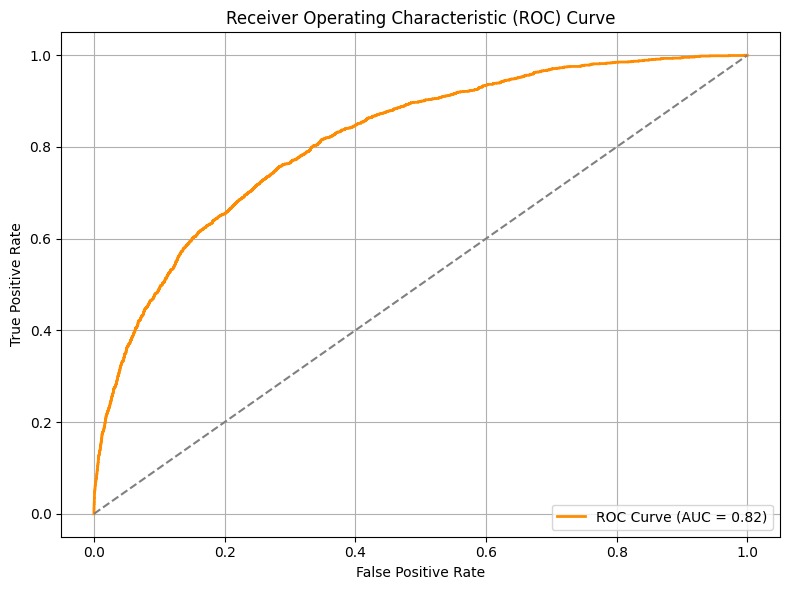

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="darkorange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Model evaluation

In [27]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

print("Classification Report (Threshold = 0.3):")
print(classification_report(y_test, y_pred_adjusted))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

print(f"\nAccuracy:  {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_adjusted):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_adjusted):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_adjusted):.4f}")



Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     10820
           1       0.31      0.73      0.44      1764

    accuracy                           0.74     12584
   macro avg       0.63      0.73      0.63     12584
weighted avg       0.86      0.74      0.77     12584


Confusion Matrix:
[[7978 2842]
 [ 476 1288]]

Accuracy:  0.7363
Precision: 0.3119
Recall:    0.7302
F1-Score:  0.4371


## Feature importance

Average gain or split frequency of features

does not explains individual predictions

can mislead if features are correlated


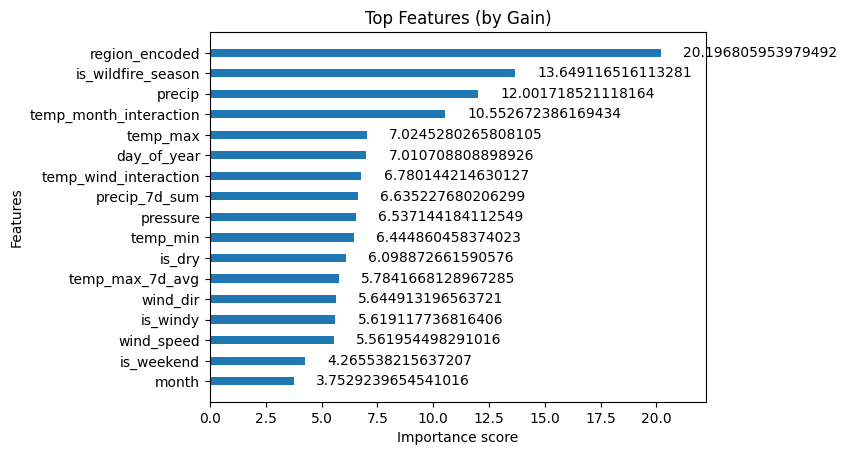

In [28]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model, max_num_features=35, importance_type='gain', height=0.4)
plt.title("Top Features (by Gain)")
plt.grid(False)
plt.show()

## Threshold Optimization Curve 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

def plot_precision_recall_thresholds(y_true, y_probs, show_f1=True):
    """
    Plots precision, recall, and F1 score against decision thresholds.
    
    Args:
        y_true (array): Ground truth binary labels
        y_probs (array): Predicted probabilities for class 1
        show_f1 (bool): Whether to also plot F1 score
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
    plt.plot(thresholds, recalls[:-1], label='Recall', linestyle='-')
    if show_f1:
        plt.plot(thresholds, f1s[:-1], label='F1 Score', linestyle='-.')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall and F1 vs Threshold')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Print the best threshold based on F1
    best_idx = np.argmax(f1s)
    best_threshold = thresholds[best_idx]
    print(f"Best F1 Score = {f1s[best_idx]:.4f} at Threshold = {best_threshold:.2f}")

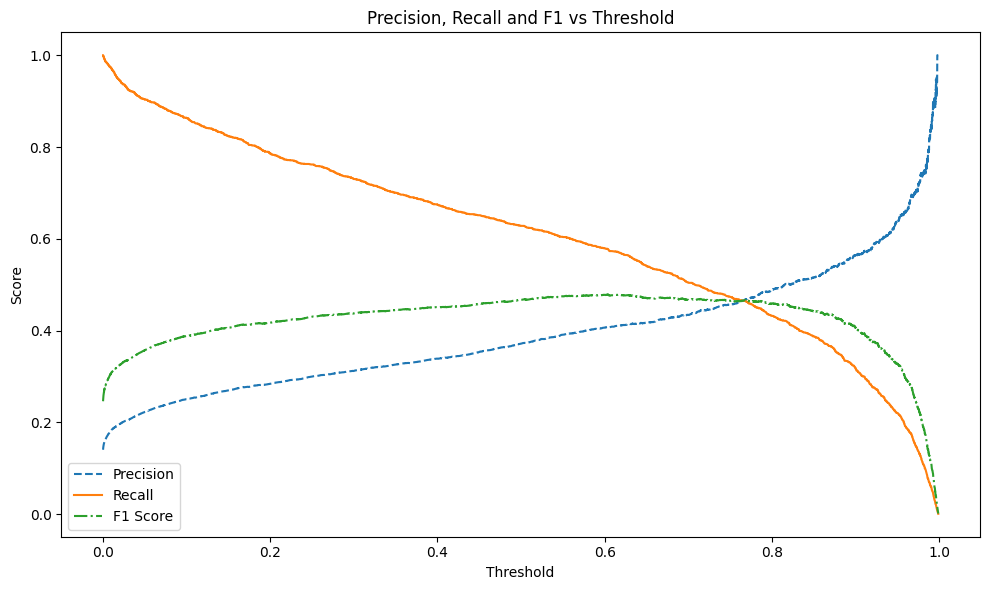

Best F1 Score = 0.4785 at Threshold = 0.60


In [31]:
y_probs = best_model.predict_proba(X_test)[:, 1]  # get probabilities for class 1
plot_precision_recall_thresholds(y_test, y_probs)

## SHAP

Evaluation first tells you how well your model is doing overall.

SHAP after helps explain why the model made specific predictions

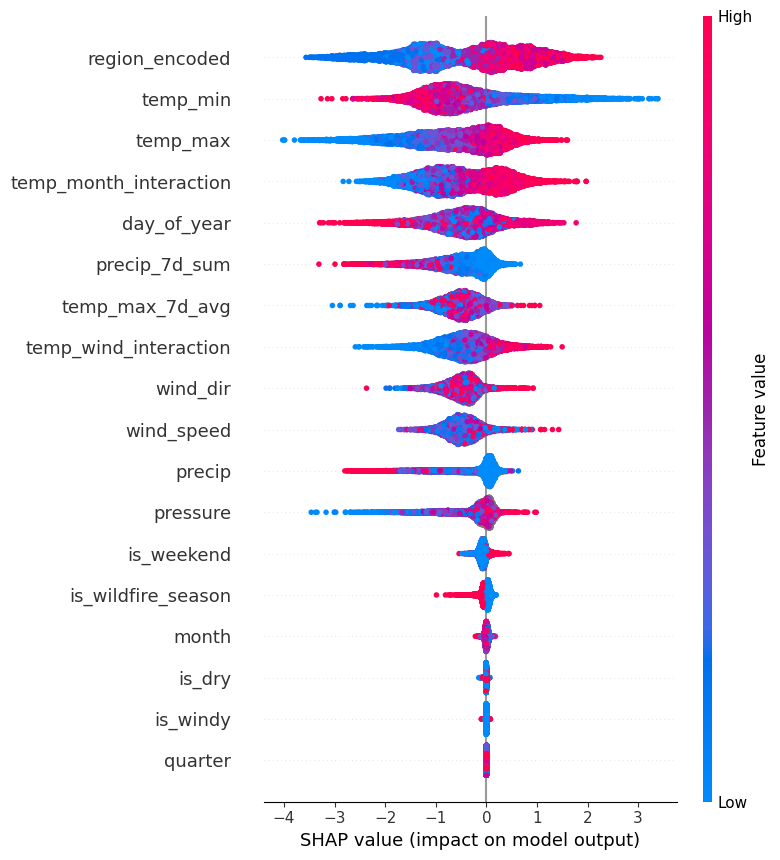

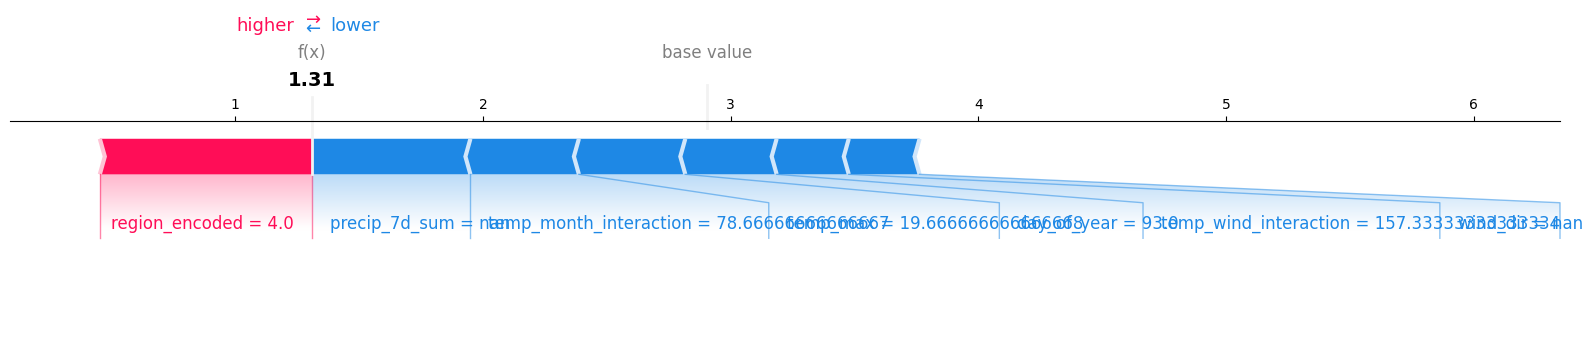

<Figure size 640x480 with 0 Axes>

In [35]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Step 1: Create SHAP Explainer
# =============================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# =============================
# Step 2: Global Summary Plot (Violin-style)
# =============================
# This shows the top features across all samples
shap.summary_plot(shap_values, X_test, max_display=20)

# Optionally save a high-res version
# shap.summary_plot(shap_values, X_test, show=False)
# plt.tight_layout()
# plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
# plt.show()

# =============================
# Step 3: Local Force Plot (Top-N Feature Version)
# =============================

sample_idx = 0  # sample to explain

# Sort and reduce to top-N most impactful features for readability
top_n = 7
shap_val_sample = shap_values[sample_idx]
top_idx = np.argsort(np.abs(shap_val_sample))[-top_n:]
top_features = X_test.iloc[sample_idx, top_idx]
top_shap_values = shap_val_sample[top_idx]

# Static force plot (matplotlib readable)
shap.initjs()  # Only needed for interactive JS plot (optional in notebook)
shap.force_plot(
    explainer.expected_value,
    top_shap_values,
    top_features,
    matplotlib=True
)

plt.tight_layout()
plt.savefig("shap_force_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Decode region mappings

The weather API should encode region label the same as the prediction model

In [ ]:
region_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(region_mapping)  

{np.int64(0): 'Aegean', np.int64(1): 'Attica', np.int64(2): 'Crete', np.int64(3): 'EpirusandWesternMacedonia', np.int64(4): 'MacedoniaandThrace', np.int64(5): 'Peloponnese,WesternGreeceand', np.int64(6): 'ThessalyandCentralGreece'}


# Wildfire Alert System – High-Risk Day Detection - DIMITRIS

In [37]:
import pandas as pd
import numpy as np

# Example weather forecast data (you will replace this with real forecast input)
forecast_data = pd.DataFrame({
    'region_encoded': [2, 1],
    'temp_max': [36.0, 30.5],
    'temp_min': [25.0, 20.2],
    'precip': [0.0, 2.1],
    'wind_dir': [270, 180],
    'wind_speed': [28, 15],
    'pressure': [1005, 1012],
    'month': [7, 7],
    'day_of_year': [198, 198],
    'weekday': [2, 2],
    'is_weekend': [0, 0],
    'quarter': [3, 3],
    'is_wildfire_season': [1, 1],
    'temp_month_interaction': [36.0 * 7, 30.5 * 7],
    'prcp_3d_sum': [0.0, 3.2],
    'prcp_7d_sum': [0.0, 4.0],
    'tmax_7d_avg': [35.0, 31.0],
    'is_dry': [1, 1],
    'fire_risk_index': [0.4 * 36 + 0.4 * 28 - 0.2 * 0, 0.4 * 30.5 + 0.4 * 15 - 0.2 * 2.1],
    'is_windy': [1, 0],
    'temp_wind_interaction': [36.0 * 28, 30.5 * 15]
})

# Predict wildfire probability
fire_probabilities = best_model.predict_proba(forecast_data)[:, 1]
forecast_data['fire_probability'] = fire_probabilities

# Alert level classification logic
def classify_alert(prob):
    if prob >= 0.7:
        return "HIGH"
    elif prob >= 0.4:
        return "MODERATE"
    else:
        return "LOW"

forecast_data['alert_level'] = forecast_data['fire_probability'].apply(classify_alert)

# Optional: map region_encoded back to region name if needed
# forecast_data['region'] = region_label_encoder.inverse_transform(forecast_data['region_encoded'])

# Final table (this can be passed to your agent layer)
forecast_output = forecast_data[['region_encoded', 'fire_probability', 'alert_level']]

ValueError: feature_names mismatch: ['temp_max', 'temp_min', 'precip', 'wind_dir', 'wind_speed', 'pressure', 'month', 'day_of_year', 'is_weekend', 'quarter', 'is_wildfire_season', 'temp_month_interaction', 'precip_7d_sum', 'temp_max_7d_avg', 'is_dry', 'fire_risk_index', 'temp_wind_interaction', 'is_windy', 'region_encoded'] ['region_encoded', 'temp_max', 'temp_min', 'precip', 'wind_dir', 'wind_speed', 'pressure', 'month', 'day_of_year', 'weekday', 'is_weekend', 'quarter', 'is_wildfire_season', 'temp_month_interaction', 'prcp_3d_sum', 'prcp_7d_sum', 'tmax_7d_avg', 'is_dry', 'fire_risk_index', 'is_windy', 'temp_wind_interaction']
expected precip_7d_sum, temp_max_7d_avg in input data
training data did not have the following fields: prcp_7d_sum, tmax_7d_avg, prcp_3d_sum, weekday